In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np
import copy
import scipy

c:\msc_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
G = nx.Graph()

In [3]:
# read the data file and convert it to a dictionary
# dictionary = {testcase ID (int): {"testcase": testcase name, "exec_line": list of executed lines}}
D = dict()
key_count = 0
previous_test_case = ''
with open('dataset/assertj-core1_2013.txt') as f:
    for line in f:
        l_line = line.rstrip().split("\t")
        if previous_test_case != l_line[1]:
            previous_test_case = l_line[1]
            key_count += 1
        if key_count in D:
            D[key_count]["exec_line"].append(l_line[2]+l_line[3])
        else:
            D[key_count] = {"testcase": l_line[1], "exec_line":[l_line[2]+l_line[3]]}



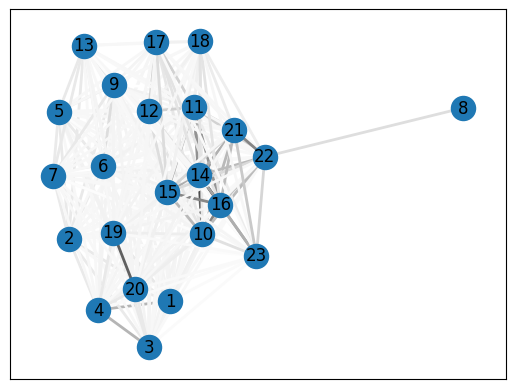

In [4]:
# Create a graph
# networkx's document is refered.
# https://networkx.org/documentation/stable/tutorial.html

# add nodes
for i in D:
    # print(i)
    # print(D[i]["testcase"])
    G.add_node(i)

# add weighted edge: the number of common executed lines is the weight of edge.
for i in range(1, len(D)+1):
    for j in range(i+1, len(D)+1):
        weight = len(set(D[i]["exec_line"]) & set(D[j]["exec_line"]))
        if weight != 0:
            G.add_weighted_edges_from([(i,j,weight)])

edges = G.edges(data=True)
weight_set = ()

# draw the graph with colored edges according to the weight.
# the code "edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())"
# refers to : https://www.tutorialspoint.com/colouring-the-edges-by-weight-in-networkx-matplotlib
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw_networkx(G,width=2, edge_color=weights, edge_cmap=plt.cm.Greys)
               
               
    

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 109.48it/s]


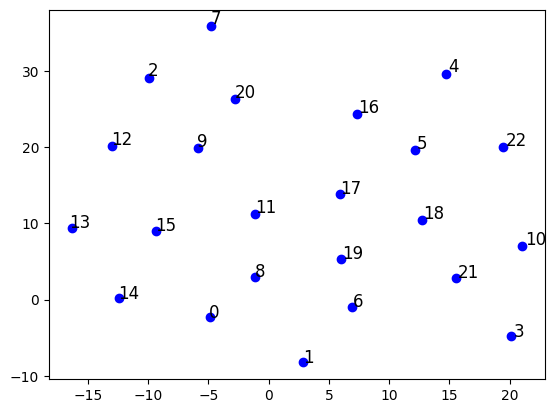

In [5]:
# Create Embedding
# https://github.com/eliorc/node2vec
# for destination in G.neighbors(1):
#     print(destination)
#     if G[1][destination].get("weight"):
#         weight = G[1][destination].get("weight", 1)
#         print("weight between 1 and destination is:", weight)
        
node2vec = Node2Vec(G, dimensions=10)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = np.array([model.wv[x-1] for x in G.nodes])

# Save embeddings for later use
model.wv.save_word2vec_format("assertj_top2013_embedding.txt")

# reduce the dimension using t-SNE
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)
# visualise the embeddings
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# plt.show()

for i in range(len(embeddings_2d)):
    x = embeddings_2d[i][0]
    y = embeddings_2d[i][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

plt.show()

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

In [49]:
# implement NLC(i)
# nx.draw_networkx(copy_G_for_k_shell)

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from operator import itemgetter

def getKShellDict(G):

    # get the max degree
    max_degree = 0
    degree_list = []
    for i in range(0,len(list(G))):
        degree_list.append((list(G)[i], G.degree(weight='weight')[list(G)[i]]))
        if max_degree < G.degree(weight='weight')[list(G)[i]]:
            max_degree = G.degree(weight='weight')[list(G)[i]]
    
    degree_list.sort(key = lambda x: x[1])
    

    copy_G_for_k_shell = copy.deepcopy(G)
    k_shell_dict = dict()
    k_shell_value = 0

    each_k_shell_count = 0 

    for k_shell_value in tqdm(range(0, max_degree+1), desc="getting k-shell values"):
        each_value_finish_flg = False
        while not each_value_finish_flg:
            each_k_shell_count = 0
            for i in range(0, len(list(G))):


                if G.degree(weight='weight')[degree_list[i][0]] > k_shell_value:
                    break
        
                else:
                    
                # if G.degree(weight='weight')[degree_list[i][0]] <= k_shell_value:
                    each_k_shell_count += 1
                    k_shell_dict[degree_list[i][0]] = k_shell_value
                    copy_G_for_k_shell.remove_node(degree_list[i][0])
                    # i += 1


            if each_k_shell_count == 0:
                each_value_finish_flg = True
            else:
                G = copy.deepcopy(copy_G_for_k_shell)
                degree_list = []
                for i in range(0,len(list(G))):
                    degree_list.append((list(G)[i], G.degree(weight='weight')[list(G)[i]]))
                    degree_list.sort(key = lambda x: x[1])

    print("return k_shell_dict!")            
    return k_shell_dict



# return the set of nodes which are in the theid-level neighborhoods of node i
def thirdLevelNeighbors(G, i):
    first_neighbors = set([n for n in G.neighbors(i)])
    result_neighbors = set()
    result_neighbors = result_neighbors | first_neighbors
    
    second_neighbors = set()
    for j in tqdm(first_neighbors, desc="searching second-level neighbors"):
        second_neighbors = first_neighbors | set([n for n in G.neighbors(j)])

    third_neighbors = set()
    for j in tqdm(second_neighbors, desc="searching third-level neighbors"):
        third_neighbors = third_neighbors | set([n for n in G.neighbors(j)])

    print("return the neighbors")

    return first_neighbors | second_neighbors | third_neighbors


# calculate NLC of node n
def getNLC(G, k, n):
    k_shell = k

    neighbors = thirdLevelNeighbors(G,n)

    node2vec_dict = dict()

    with open("assertj_top2013_embedding.txt") as f:
        for line in tqdm(f,desc="reading embeddings"):
            data  =  line.rstrip().split(" ")
            float_data = []
            for i in data:
                float_data.append(float(i))
            node2vec_dict[int(float_data[0])] = float_data[1:]


    print("read the embeddings text file")

    NLC = 0

    for j in tqdm(neighbors, desc="calculating NLC"):
        x1 = node2vec_dict[n]
        x2 = node2vec_dict[j]
        ed = scipy.spatial.distance.euclidean(node2vec_dict[n], node2vec_dict[j])
        
        NLC = NLC + k_shell[n]* np.exp(-ed)
    
    print("return NLC")

    return NLC



result = ""
k_shell_d = getKShellDict(G)
# with ProcessPoolExecutor(8) as exe:
#     # for node, nlc in zip(list(G), exe.map(getNLC, zip(k_shell_d * len(list(G)), G*len(list(G)),  list(G)))):
#     for node, nlc in zip(list(G), exe.map(getNLC, zip(G, k_shell_d, list(G)))):
#         result += (str(node) + " " + str(nlc) + "\n")
print("k_shell_d", k_shell_d)
# for node in list(G):
#     nlc = getNLC(G, k_shell_d, node)
#     result += (str(node) + " " + str(nlc) + "\n")

with open("assertj_top2013_nlc.txt", "w") as f:
    f.write(result)

getting k-shell values:   0%|          | 0/872 [00:00<?, ?it/s]

getting k-shell values: 100%|██████████| 872/872 [00:00<00:00, 43733.51it/s]

return k_shell_dict!
k_shell_d {8: 38, 7: 307, 13: 307, 5: 307, 2: 307, 6: 307, 9: 307, 18: 307, 3: 314, 4: 314, 1: 314, 19: 314, 20: 314, 12: 314, 17: 314, 23: 314, 22: 341, 21: 341, 15: 341, 11: 341, 10: 341, 16: 341, 14: 341}


In [7]:
!pip freeze > requirements.txt

In [8]:
!python --version

Python 3.10.2
